## Project Imports

In [1]:
import pandas as pd

#acquire and prep
from env import github_token, github_username
import acquire
import prepare

import os
import json
from typing import Dict, List, Optional, Union, cast
import requests

import re
import unicodedata
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

#visualize
from wordcloud import WordCloud
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

#ignore warnings (turn off pink warning boxes)
import warnings
warnings.filterwarnings("ignore")

#tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

#train, validate, test
from sklearn.model_selection import train_test_split

#creating / evaluating models
# Decision Tree  
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

# Random Forest
from sklearn.ensemble import RandomForestClassifier

# K-Nearest Neighbor(KNN)  
from sklearn.neighbors import KNeighborsClassifier

# Logistic Regression
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report, accuracy_score

# Data Acquisition

In [2]:
"""
A module for obtaining repo readme and language data from the github API.

Before using this module, read through it, and follow the instructions marked
TODO.

After doing so, run it like this:

    python acquire.py

To create the `data.json` file that contains the data.
"""
import os
import json
from typing import Dict, List, Optional, Union, cast
import requests

from env import github_token, github_username

# TODO: Make a github personal access token.
#     1. Go here and generate a personal access token https://github.com/settings/tokens
#        You do _not_ need select any scopes, i.e. leave all the checkboxes unchecked
#     2. Save it in your env.py file under the variable `github_token`
# TODO: Add your github username to your env.py file under the variable `github_username`
# TODO: Add more repositories to the `REPOS` list below.

REPOS = [
    "freeCodeCamp/freeCodeCamp",
    "vuejs/vue",
    "facebook/react",
    "tensorflow/tensorflow",
    "twbs/bootstrap",
    "donnemartin/system-design-primer",
    "ohmyzsh/ohmyzsh",
    "public-apis/public-apis",
    "microsoft/vscode",
    "torvalds/linux",
    "airbnb/javascript",
    "trekhleb/javascript-algorithms",
    "TheAlgorithms/Python",
    "d3/d3",
    "facebook/react-native",
    "ytdl-org/youtube-dl",
    "electron/electron",
    "axios/axios",
    "facebook/create-react-app",
    "nodejs/node",
    "kubernetes/kubernetes",
    "30-seconds/30-seconds-of-code",
    "microsoft/terminal",
    "tensorflow/models",
    "vercel/next.js",
    "iluwatar/java-design-patterns",
    "FortAwesome/Font-Awesome",
    "goldbergyoni/nodebestpractices",
    "laravel/laravel",
    "nvbn/thefuck",
    "atom/atom",
    "spring-projects/spring-boot",
    "elastic/elasticsearch",
    "jquery/jquery",
    "microsoft/PowerToys",
    "opencv/opencv",
    "typicode/json-server",
    "netdata/netdata",
    "keras-team/keras",
    "chrislgarry/Apollo-11",
    "httpie/httpie",
    "josephmisiti/awesome-machine-learning",
    "h5bp/html5-boilerplate",
    "lodash/lodash",
    "Semantic-Org/Semantic-UI",
    "h5bp/Front-end-Developer-Interview-Questions",
    "redis/redis",
    "yangshun/tech-interview-handbook",
    "chartjs/Chart.js",
    "socketio/socket.io",
    "bitcoin/bitcoin",
    "ionic-team/ionic-framework",
    "necolas/normalize.css",
    "ReactTraining/react-router",
    "huggingface/transformers",
    "scikit-learn/scikit-learn",
    "moment/moment",
    "psf/requests",
    "ReactiveX/RxJava",
    "impress/impress.js",
    "mermaid-js/mermaid",
    "Alamofire/Alamofire",
    "serverless/serverless",
    "prettier/prettier",
    "juliangarnier/anime",
    "godotengine/godot",
    "ColorlibHQ/AdminLTE",
    "apache/superset",
    "parcel-bundler/parcel",
    "square/retrofit",
    "spring-projects/spring-framework",
    "jekyll/jekyll",
    "home-assistant/core",
    "meteor/meteor",
    "jaywcjlove/awesome-mac",
    "grafana/grafana",
    "NARKOZ/hacker-scripts",
    "tailwindlabs/tailwindcss",
    "syncthing/syncthing",
    "strapi/strapi",
    "apache/dubbo",
    "deepfakes/faceswap",
    "iamkun/dayjs",
    "mozilla/pdf.js",
    "python/cpython",
    "vsouza/awesome-ios",
    "TryGhost/Ghost",
    "hexojs/hexo",
    "gulpjs/gulp",
    "alvarotrigo/fullPage.js",
    "Marak/faker.js",
    "fastlane/fastlane",
    "NationalSecurityAgency/ghidra",
    "beego/beego",
    "jashkenas/underscore",
    "skylot/jadx",
    "agalwood/Motrix",
    "pingcap/tidb",
    "bayandin/awesome-awesomeness",
    "microsoft/playwright",
    "go-gorm/gorm",
    "iview/iview",
    "cheeriojs/cheerio",
    "mobxjs/mobx",
    "GitbookIO/gitbook",
    "anuraghazra/github-readme-stats",
    "ryanoasis/nerd-fonts",
    "google-research/bert",
    "bumptech/glide",
    "airbnb/lottie-android",
    "immutable-js/immutable-js",
    "tiangolo/fastapi",
    "jondot/awesome-react-native",
    "Blankj/AndroidUtilCode",
    "FFmpeg/FFmpeg",
    "ctripcorp/apollo",
    "typescript-cheatsheets/react",
    "sherlock-project/sherlock",
    "gorhill/uBlock",
    "PowerShell/PowerShell"

]

headers = {"Authorization": f"token {github_token}", "User-Agent": github_username}

if headers["Authorization"] == "token " or headers["User-Agent"] == "":
    raise Exception(
        "You need to follow the instructions marked TODO in this script before trying to use it"
    )


def github_api_request(url: str) -> Union[List, Dict]:
    response = requests.get(url, headers=headers)
    response_data = response.json()
    if response.status_code != 200:
        raise Exception(
            f"Error response from github api! status code: {response.status_code}, "
            f"response: {json.dumps(response_data)}"
        )
    return response_data


def get_repo_language(repo: str) -> str:
    url = f"https://api.github.com/repos/{repo}"
    repo_info = github_api_request(url)
    if type(repo_info) is dict:
        repo_info = cast(Dict, repo_info)
        if "language" not in repo_info:
            raise Exception(
                "'language' key not round in response\n{}".format(json.dumps(repo_info))
            )
        return repo_info["language"]
    raise Exception(
        f"Expecting a dictionary response from {url}, instead got {json.dumps(repo_info)}"
    )


def get_repo_contents(repo: str) -> List[Dict[str, str]]:
    url = f"https://api.github.com/repos/{repo}/contents/"
    contents = github_api_request(url)
    if type(contents) is list:
        contents = cast(List, contents)
        return contents
    raise Exception(
        f"Expecting a list response from {url}, instead got {json.dumps(contents)}"
    )


def get_readme_download_url(files: List[Dict[str, str]]) -> str:
    """
    Takes in a response from the github api that lists the files in a repo and
    returns the url that can be used to download the repo's README file.
    """
    for file in files:
        if file["name"].lower().startswith("readme"):
            return file["download_url"]
    return ""


def process_repo(repo: str) -> Dict[str, str]:
    """
    Takes a repo name like "gocodeup/codeup-setup-script" and returns a
    dictionary with the language of the repo and the readme contents.
    """
    contents = get_repo_contents(repo)
    readme_download_url = get_readme_download_url(contents)
    if readme_download_url == "":
        readme_contents = ""
    else:
        readme_contents = requests.get(readme_download_url).text
    return {
        "repo": repo,
        "language": get_repo_language(repo),
        "readme_contents": readme_contents,
    }


def scrape_github_data() -> List[Dict[str, str]]:
    """
    Loop through all of the repos and process them. Returns the processed data.
    """
    return [process_repo(repo) for repo in REPOS]


if __name__ == "__main__":
    data = scrape_github_data()
    json.dump(data, open("data.json", "w"), indent=1)


In [3]:
#Acquire data from acquire.py
df = pd.read_json('data.json')
df.head()

,repo,language,readme_contents
0,freeCodeCamp/freeCodeCamp,JavaScript,![freeCodeCamp.org Social Banner](https://s3.a...
1,vuejs/vue,JavaScript,"<p align=""center""><a href=""https://vuejs.org"" ..."
2,facebook/react,JavaScript,# [React](https://reactjs.org/) &middot; [![Gi...
3,tensorflow/tensorflow,C++,"<div align=""center"">\n <img src=""https://www...."
4,twbs/bootstrap,JavaScript,"<p align=""center"">\n <a href=""https://getboot..."


In [4]:
#Columns and rows
df.shape

(120, 3)

In [5]:
#DF info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             120 non-null    object
 1   language         120 non-null    object
 2   readme_contents  120 non-null    object
dtypes: object(3)
memory usage: 2.9+ KB


In [6]:
#Value counts of languages
df.language.value_counts()

JavaScript    53
Python        19
Java          13
C++            6
TypeScript     6
Go             5
C              4
Ruby           3
Swift          2
CSS            2
C#             2
Assembly       1
Nunjucks       1
PHP            1
Vue            1
Shell          1
Name: language, dtype: int64

In [7]:
#Check for null values
df.isnull().sum()

repo               0
language           0
readme_contents    0
dtype: int64

# Data Preparation

In [8]:
#Get clean DF from prepare.py
df = prepare.clean_content(df, 'readme_contents', extra_words = ['p', 'aligncenter', 'img'], exclude_words = ['no'])

#Drop original readme_contents
df = df.drop(columns = ['readme_contents'])

df.head()

,repo,clean_content,language
0,freeCodeCamp/freeCodeCamp,freecodecamporg social bannerhttpss3amazonawsc...,JavaScript
1,vuejs/vue,aligncentera hrefhttpsvuejsorg targetblank rel...,JavaScript
2,facebook/react,reacthttpsreactjsorg middot github licensehttp...,JavaScript
3,tensorflow/tensorflow,div srchttpswwwtensorfloworgimagestflogosocial...,C++
4,twbs/bootstrap,hrefhttpsgetbootstrapcom srchttpsgetbootstrapc...,JavaScript


In [9]:
#Check to see if languages with fewer than 5 occurances were dropped
len(df.language.value_counts())

6

In [10]:
#Check how many words appear for each language and percentage
languages = pd.concat([df.language.value_counts(),
                    round(df.language.value_counts(normalize=True), 2)], axis=1)

languages.columns = ['n', 'percent']

languages

,n,percent
JavaScript,53,0.52
Python,19,0.19
Java,13,0.13
C++,6,0.06
TypeScript,6,0.06
Go,5,0.05


In [11]:
#Shape of prepped DF
df.shape

(102, 3)

# Data Exploration

In [12]:
#Breaking up data into each language

#words that appear in Python
python_words = ' '.join(df[df.language == 'Python'].clean_content)

#words that appear in JavaScript
javascript_words = ' '.join(df[df.language == 'JavaScript'].clean_content)

#words that appear in Java
java_words = ' '.join(df[df.language == 'Java'].clean_content)

#words that appear in C++
c_words = ' '.join(df[df.language == 'C++'].clean_content)

#words that appear in TypeScript
typescript_words = ' '.join(df[df.language == 'TypeScript'].clean_content)

#words that appear in Go
go_words = ' '.join(df[df.language == 'Go'].clean_content)

#all of the words 
all_lang_words = ' '.join(df.clean_content)

In [13]:
#Check how often each of the words occurs
python_freq = pd.Series(python_words.split()).value_counts()
javascript_freq = pd.Series(javascript_words.split()).value_counts()
java_freq = pd.Series(java_words.split()).value_counts()
c_freq = pd.Series(c_words.split()).value_counts()
typescript_freq = pd.Series(typescript_words.split()).value_counts()
go_freq = pd.Series(go_words.split()).value_counts()
all_lang_freq = pd.Series(all_lang_words.split()).value_counts()

print('Python:')
print(python_freq)
print('--------------------------')
print('JavaScript:')
print(javascript_freq)
print('--------------------------')
print('Java:')
print(java_freq)
print('--------------------------')
print('C:')
print(c_freq)
print('--------------------------')
print('TypeScript:')
print(typescript_freq)
print('--------------------------')
print('Go:')
print(go_freq)
print('--------------------------')
print('All Languages:')
print(all_lang_freq)

Python:
yes                                                               915
unknown                                                           594
no                                                                579
data                                                              464
learning                                                          396
                                                                 ... 
demonstration                                                       1
bloghttpsengineeringherokucom                                       1
httpsstoragegoogleapiscombertmodels20200220uncasedl2h768a12zip      1
jsdelivrhttpsgithubcomjsdelivrdatajsdelivrcom                       1
emceehttpsgithubcomdfmemcee                                         1
Length: 11513, dtype: int64
--------------------------
JavaScript:
react                          1031
native                          860
const                           498
icon                            442
use        

In [15]:
#Return one DF by combining all freq together
word_counts = (pd.concat([all_lang_freq, 
                          python_freq, 
                          javascript_freq, 
                          java_freq, 
                          c_freq, 
                          typescript_freq,
                          go_freq], axis=1, sort=True)
                .set_axis(['All', 
                           'Python', 
                           'JavaScript', 
                           'Java', 
                           'C', 
                           'TypeScript',
                           'Go'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32223 entries, &#9; to zyszyshttpsgithubcomzyszys
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   All         32223 non-null  int64
 1   Python      32223 non-null  int64
 2   JavaScript  32223 non-null  int64
 3   Java        32223 non-null  int64
 4   C           32223 non-null  int64
 5   TypeScript  32223 non-null  int64
 6   Go          32223 non-null  int64
dtypes: int64(7)
memory usage: 2.0+ MB


In [16]:
word_counts.head()

,All,Python,JavaScript,Java,C,TypeScript,Go
&#9;,260,3,231,25,0,0,1
0,90,13,70,4,1,2,0
000,1,0,1,0,0,0,0
00008384,1,0,0,0,0,0,1
00042,1,1,0,0,0,0,0


In [18]:
#Additional cleanup to reduce noise
#remove `&#9;` characters
python_words = re.sub(r'&#9;', '', python_words)
javascript_words = re.sub(r'&#9;', '', javascript_words)
java_words = re.sub(r'&#9;', '', java_words)
c_words = re.sub(r'&#9;', '', c_words)
typescript_words = re.sub(r'&#9;', '', typescript_words)
go_words = re.sub(r'&#9;', '', go_words)
all_lang_words = re.sub(r'&#9;', '', all_lang_words)

#remove single characters
python_words = re.sub(r'\s.\s', '', python_words)
javascript_words = re.sub(r'\s.\s', '', javascript_words)
java_words = re.sub(r'\s.\s', '', java_words)
c_words = re.sub(r'\s.\s', '', c_words)
typescript_words = re.sub(r'\s.\s', '', typescript_words)
go_words = re.sub(r'\s.\s', '', go_words)
all_lang_words = re.sub(r'\s.\s', '', all_lang_words)

#remove words with 20 or more characters
python_words = re.sub(r'\b\w{20,}\b', '', python_words)
javascript_words = re.sub(r'\b\w{20,}\b', '', javascript_words)
java_words = re.sub(r'\b\w{20,}\b', '', java_words)
c_words = re.sub(r'\b\w{20,}\b', '', c_words)
typescript_words = re.sub(r'\b\w{20,}\b', '', typescript_words)
go_words = re.sub(r'\b\w{20,}\b', '', go_words)
all_lang_words = re.sub(r'\b\w{20,}\b', '', all_lang_words)

#filter out all words that occur less than 20 times
word_counts = word_counts[word_counts['All'] >= 20]

In [19]:
word_counts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 999 entries, &#9; to zure
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   All         999 non-null    int64
 1   Python      999 non-null    int64
 2   JavaScript  999 non-null    int64
 3   Java        999 non-null    int64
 4   C           999 non-null    int64
 5   TypeScript  999 non-null    int64
 6   Go          999 non-null    int64
dtypes: int64(7)
memory usage: 62.4+ KB


In [20]:
word_counts.head(10)

,All,Python,JavaScript,Java,C,TypeScript,Go
&#9;,260,3,231,25,0,0,1
0,90,13,70,4,1,2,0
1,425,126,282,13,1,2,1
10,67,21,30,12,2,2,0
100,35,14,18,0,0,2,1
2,237,42,181,11,2,0,1
20,39,16,10,8,2,1,2
2018,21,9,10,2,0,0,0
3,154,22,116,10,2,2,2
4,86,21,57,6,0,1,1


In [21]:
word_counts.tail(10)

,All,Python,JavaScript,Java,C,TypeScript,Go
wrong,23,18,3,1,0,1,0
x,95,20,72,2,0,1,0
xml,23,5,0,6,0,12,0
yarn,37,5,32,0,0,0,0
yes,918,915,3,0,0,0,0
yet,21,1,15,4,1,0,0
youre,47,15,27,1,2,2,0
youtube,37,27,10,0,0,0,0
youtubedl,153,153,0,0,0,0,0
zure,83,0,83,0,0,0,0


In [22]:
#Check how often each of the words occurs
python_freq = pd.Series(python_words.split()).value_counts()
javascript_freq = pd.Series(javascript_words.split()).value_counts()
java_freq = pd.Series(java_words.split()).value_counts()
c_freq = pd.Series(c_words.split()).value_counts()
typescript_freq = pd.Series(typescript_words.split()).value_counts()
go_freq = pd.Series(go_words.split()).value_counts()
all_lang_freq = pd.Series(all_lang_words.split()).value_counts()

print('Python:')
print(python_freq)
print('--------------------------')
print('JavaScript:')
print(javascript_freq)
print('--------------------------')
print('Java:')
print(java_freq)
print('--------------------------')
print('C:')
print(c_freq)
print('--------------------------')
print('TypeScript:')
print(typescript_freq)
print('--------------------------')
print('Go:')
print(go_freq)
print('--------------------------')
print('All Languages:')
print(all_lang_freq)

Python:
yes             913
unknown         592
no              577
data            460
learning        394
               ... 
arpa              1
mathematisch      1
packaging         1
matlabmatlab      1
gvsearch2         1
Length: 8316, dtype: int64
--------------------------
JavaScript:
react             1028
native             856
icon               441
const              401
use                391
                  ... 
averylongclass       1
typically            1
ascii                1
exampleemail         1
measuring            1
Length: 12851, dtype: int64
--------------------------
Java:
tdimg           289
alttd           269
tr              200
td              168
aligncentera    167
               ... 
explicitly        1
watch             1
stored            1
subbtoxic         1
subbleo           1
Length: 2333, dtype: int64
--------------------------
C:
window        64
terminal      45
tensorflow    32
electron      29
install       24
              ..
altgodot     

## What are the most frequently occuring words in READMEs for each language?

In [23]:
#getting top word counts and sorting the values
word_counts.sort_values(by='All', ascending=False).head(10)

,All,Python,JavaScript,Java,C,TypeScript,Go
react,1043,2,1031,1,0,9,0
yes,918,915,3,0,0,0,0
native,879,12,860,1,1,2,3
no,683,579,84,13,3,3,1
use,672,218,393,34,8,10,9
data,599,464,113,9,1,10,2
unknown,597,594,3,0,0,0,0
const,534,0,498,0,3,33,0
using,522,173,305,20,9,11,4
file,448,244,163,29,5,3,4


## Are there any words that uniquely identify a programming language?

In [24]:
#concat the word counts for each programming language into a df
pd.concat([word_counts[word_counts.Python == 0].sort_values(by='Python').head(10),
           word_counts[word_counts.JavaScript == 0].sort_values(by='JavaScript').head(10), 
           word_counts[word_counts.Java == 0].sort_values(by='Java').head(10), 
           word_counts[word_counts.C == 0].sort_values(by='C').head(10), 
           word_counts[word_counts.TypeScript == 0].sort_values(by='TypeScript').head(10),
           word_counts[word_counts.Go == 0].sort_values(by='Go').head(10)])

,All,Python,JavaScript,Java,C,TypeScript,Go
adibidez,46,0,46,0,0,0,0
runkitactivate,21,0,21,0,0,0,0
router,21,0,21,0,0,0,0
responsive,27,0,27,0,0,0,0
requireimmutable,23,0,23,0,0,0,0
ref,21,0,21,0,0,0,0
redux,43,0,42,0,0,1,0
prop,98,0,98,0,0,0,0
probak,20,0,20,0,0,0,0
proba,22,0,22,0,0,0,0


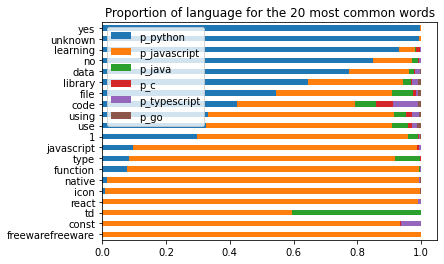

In [25]:
#visualize percentage for each language
(word_counts
 .assign(p_python=word_counts.Python / word_counts['All'],
         p_javascript=word_counts.JavaScript / word_counts['All'], 
         p_java=word_counts.Java / word_counts['All'], 
         p_c=word_counts.C / word_counts['All'], 
         p_typescript=word_counts.TypeScript / word_counts['All'],
         p_go=word_counts.Go / word_counts['All'])
 .sort_values(by='All')
 [['p_python', 'p_javascript', 'p_java', 'p_c', 'p_typescript', 'p_go']]
 .tail(20)
 .sort_values('p_python')
 .plot.barh(stacked=True))

plt.title('Proportion of language for the 20 most common words')
plt.show()

## What are the top word combinations (bigrams and trigrams)?

In [27]:
#Create variables for most common bigrams for each language
python_bigrams = (pd.Series(nltk.ngrams(python_words.split(), 2))
                      .value_counts()
                      .head(20))
javascript_bigrams = (pd.Series(nltk.ngrams(javascript_words.split(), 2))
                      .value_counts()
                      .head(20))
java_bigrams = (pd.Series(nltk.ngrams(java_words.split(), 2))
                      .value_counts()
                      .head(20))
c_bigrams = (pd.Series(nltk.ngrams(c_words.split(), 2))
                      .value_counts()
                      .head(20))
typescript_bigrams = (pd.Series(nltk.ngrams(typescript_words.split(), 2))
                      .value_counts()
                      .head(20))
go_bigrams = (pd.Series(nltk.ngrams(go_words.split(), 2))
                      .value_counts()
                      .head(20))
all_bigrams = (pd.Series(nltk.ngrams(all_lang_words.split(), 2))
                      .value_counts()
                      .head(20))

In [28]:
#Create variables for most common trigrams for each language
python_trigrams = (pd.Series(nltk.ngrams(python_words.split(), 3))
                      .value_counts()
                      .head(20))
javascript_trigrams = (pd.Series(nltk.ngrams(javascript_words.split(), 3))
                      .value_counts()
                      .head(20))
java_trigrams = (pd.Series(nltk.ngrams(java_words.split(), 3))
                      .value_counts()
                      .head(20))
c_trigrams = (pd.Series(nltk.ngrams(c_words.split(), 3))
                      .value_counts()
                      .head(20))
typescript_trigrams = (pd.Series(nltk.ngrams(typescript_words.split(), 3))
                      .value_counts()
                      .head(20))
go_trigrams = (pd.Series(nltk.ngrams(go_words.split(), 3))
                      .value_counts()
                      .head(20))
all_trigrams = (pd.Series(nltk.ngrams(all_lang_words.split(), 3))
                      .value_counts()
                      .head(20))

## Python Bigrams/Trigrams and Word Clouds

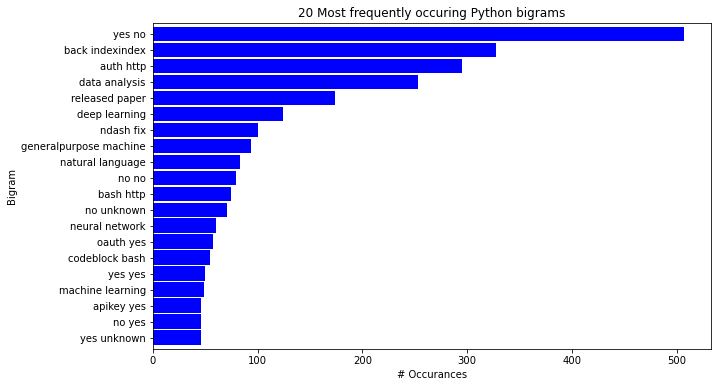

In [29]:
#bigrams
python_bigrams.sort_values().plot.barh(color='blue', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring Python bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

#labels
ticks, _ = plt.yticks()
labels = python_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

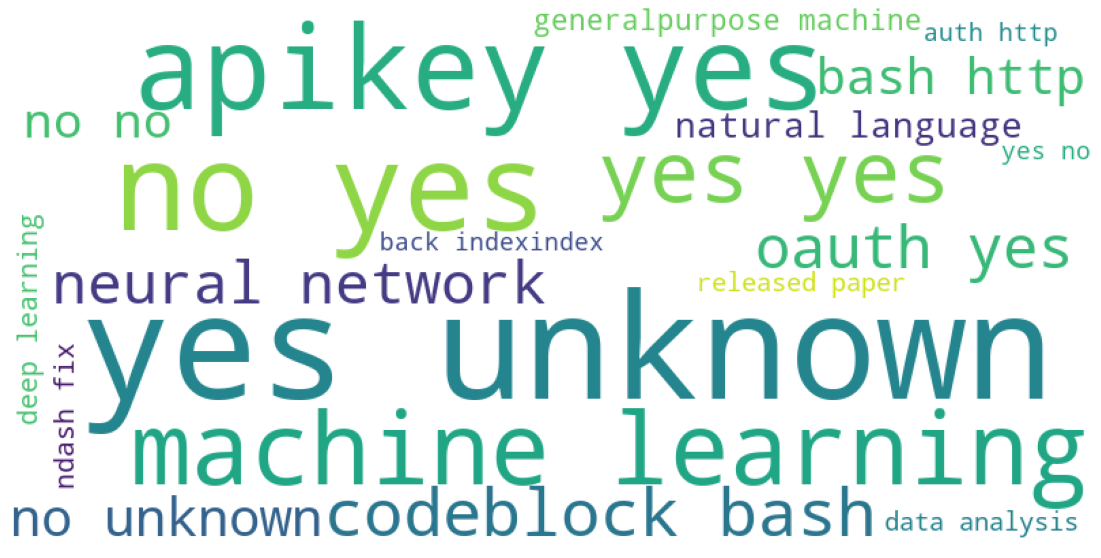

In [30]:
#Use python bigrams to make word cloud
data = {k[0] + ' ' + k[1]: v for k, v in python_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(20, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

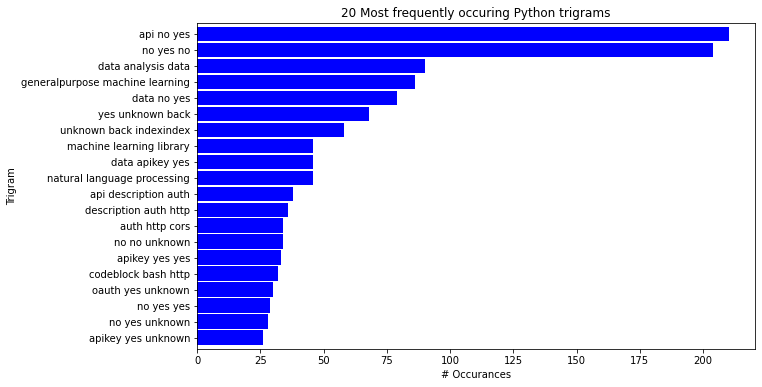

In [34]:
#trigrams
python_trigrams.sort_values().plot.barh(color='blue', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring Python trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

#labels
ticks, _ = plt.yticks()
labels = python_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

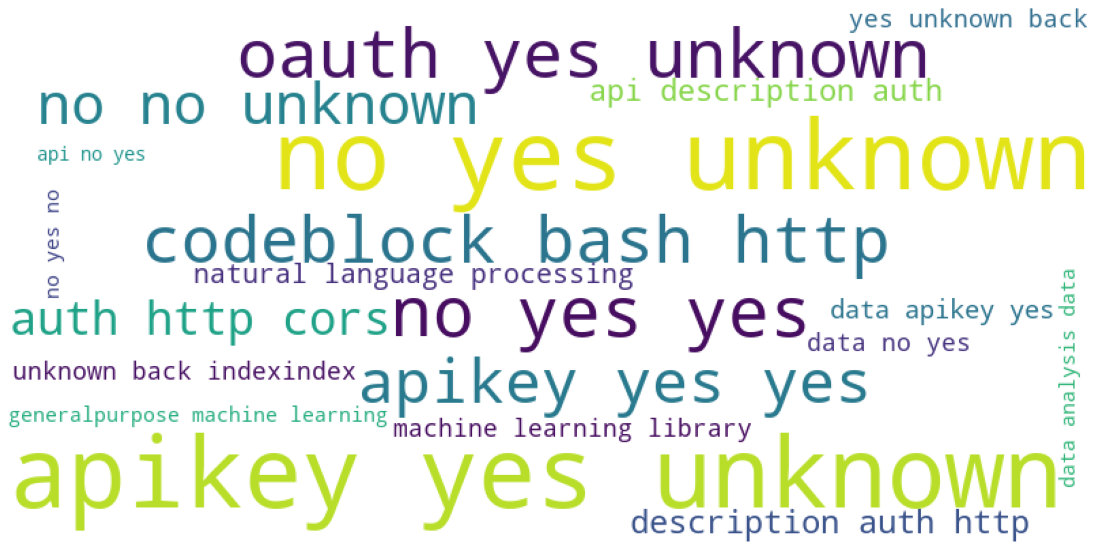

In [35]:
#use python trigrams to make word cloud
data = {k[0] + ' ' + k[1] + ' ' + k[2]: v for k, v in python_trigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(20, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

## JavaScript Bigrams / Trigrams and Word Clouds


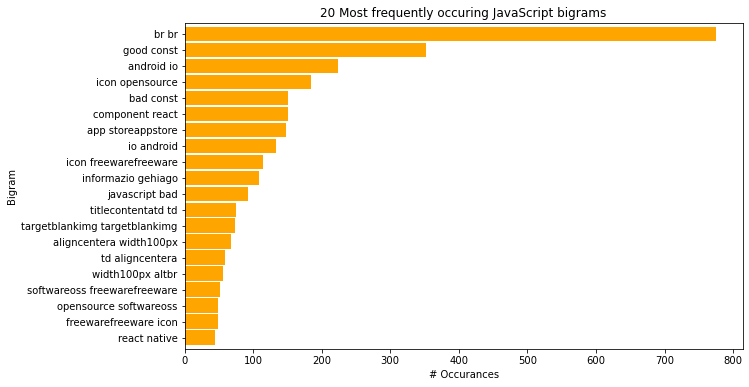

In [32]:
#bigrams
javascript_bigrams.sort_values().plot.barh(color='orange', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring JavaScript bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

#labels
ticks, _ = plt.yticks()
labels = javascript_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

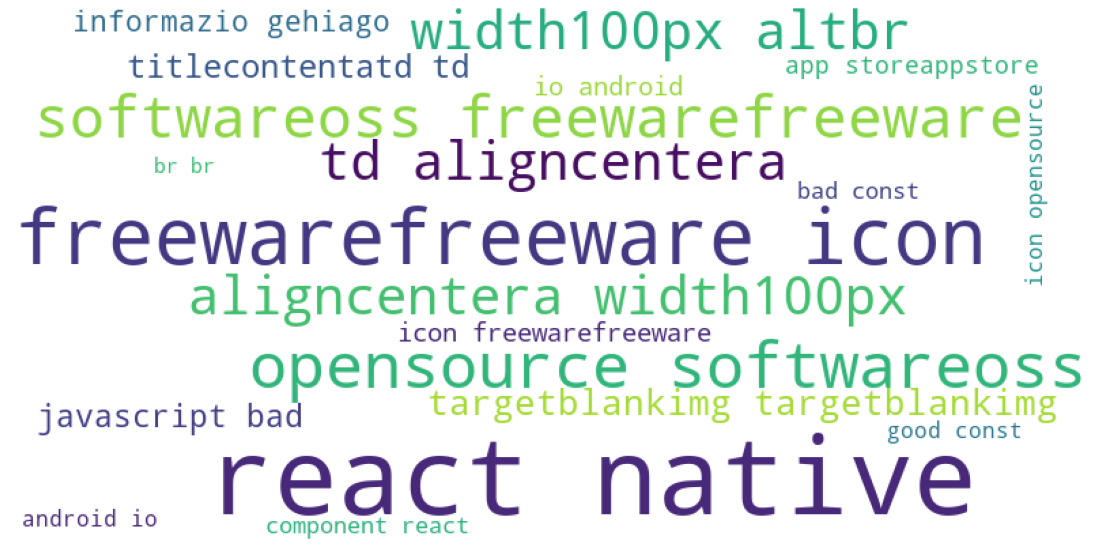

In [33]:
#use javascript bigrams to make word cloud
data = {k[0] + ' ' + k[1]: v for k, v in javascript_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(20, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

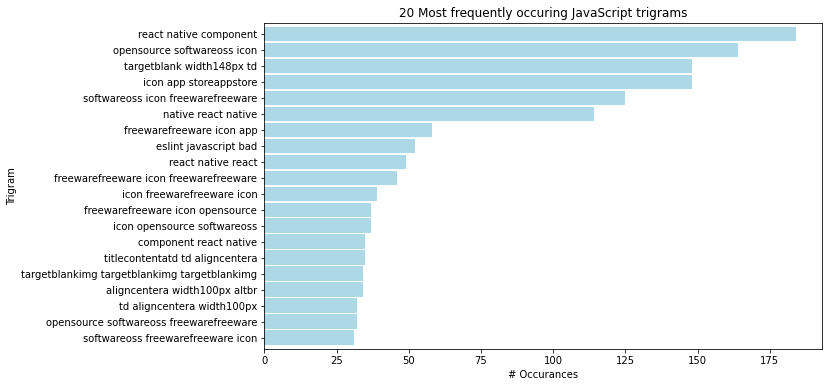

In [36]:
#trigrams
javascript_trigrams.sort_values().plot.barh(color='orange', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring JavaScript trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

#labels
ticks, _ = plt.yticks()
labels = javascript_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)